# Upstroke

Team 3

## Setup

In [1]:
#pip install pynamics

In [2]:
%matplotlib inline
import scipy.optimize
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
plt.ion()
from math import pi, sin, cos, tan, asin, acos, atan, degrees, radians, pi

In [3]:
def prettyplot(x,y): # Function plots mechanism and generates labels
    # Create Figure
    Fig1 = plt.figure(figsize=[15,10])
    ax = Fig1.add_axes([0.0, 0.0, 1.0, 1.0], aspect='equal')
    #ax.patch.set_alpha(0.0)
    
    # plot links and joints
    plt.plot(x[0:3],y[0:3],color='tab:blue')
    plt.plot(x[2:5],y[2:5],color='tab:green')
    plt.plot(x[4:],y[4:],color='k')
    plt.scatter(x,y,color='k')
    plt.axis('equal')
    plt.xlim([-0.1,0.5])
    
    # label joints
    for i in range(0, len(x)-1):
        plt.text(x[i]-0.004, y[i]-0.004, "p"+str(i), verticalalignment='top', horizontalalignment='right', fontsize=14)
    
    # plot COMs
    comx = [(x[0]+x[1])/2, (x[1]+x[2])/2, (x[4]+x[3])/2, (x[3]+x[2])/2, (x[4]+x[0])/2]
    comy = [(y[0]+y[1])/2, (y[1]+y[2])/2, (y[4]+y[3])/2, (y[3]+y[2])/2, (y[4]+y[0])/2]
    plt.scatter(comx,comy,color='k')
    
    # label COMs
    linknames = ['A', 'B', 'C', 'D', 'E']
    for i in range(0, len(comx)):
        plt.text(comx[i]+0.004, comy[i], linknames[i], verticalalignment='bottom', horizontalalignment='left', weight='bold', fontsize=16)
    
    # label properties
    propertynames = ['La', 'Lb', 'Lc', 'Ld', 'Le']
    for i in range(0, len(comx)):
        plt.text(comx[i]+0.016, comy[i], propertynames[i], verticalalignment='bottom', horizontalalignment='left', fontsize=14)
    
    
    # plot frame axes
    alen = 0.04    
    plt.arrow(0, 0, alen, 0,head_width=0.008,width=0.0004,color='r')
    plt.arrow(0, 0, 0, alen,head_width=0.008,width=0.0004,color='r')
    vx = []
    vy = []
    for i in range(1, len(x)-2):
        if i <= 2: 
            vecx = numpy.array([x[i]-x[i-1], y[i]-y[i-1]])
            vecx = vecx/(vecx.dot(vecx)**0.5)
            vecy = numpy.cross([0,0,1], vecx)[0:2]
            plt.arrow(x[i], y[i], alen*vecx[0], alen*vecx[1],head_width=0.008,width=0.0004,color='b')
            plt.arrow(x[i], y[i], alen*vecy[0], alen*vecy[1],head_width=0.008,width=0.0004,color='b')
            vx.append(vecx)
            vy.append(vecy)
        if i >= 2:
            vecx = numpy.array([x[i]-x[i+1], y[i]-y[i+1]])
            vecx = vecx/(vecx.dot(vecx)**0.5)
            vecy = numpy.cross([0,0,1], vecx)[0:2]
            plt.arrow(x[i], y[i], alen*vecx[0], alen*vecx[1],head_width=0.008,width=0.0004,color='g')
            plt.arrow(x[i], y[i], alen*vecy[0], alen*vecy[1],head_width=0.008,width=0.0004,color='g')
            vx.append(vecx)
            vy.append(vecy)

    # label frames
    lablen = 0.06

    plt.text(x[0]+0.06, y[0], 'Nx', verticalalignment='center', horizontalalignment='center', color='r', fontsize=14)
    plt.text(x[0], y[0]+0.06, 'Ny', verticalalignment='center', horizontalalignment='center', color='r', fontsize=14)
    
    plt.text(x[1]+lablen*vx[0][0], y[1]+lablen*vx[0][1], 'Ax', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)
    plt.text(x[1]+lablen*vy[0][0], y[1]+lablen*vy[0][1], 'Ay', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)

    plt.text(x[2]+lablen*vx[1][0], y[2]+lablen*vx[1][1], 'Bx', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)
    plt.text(x[2]+lablen*vy[1][0], y[2]+lablen*vy[1][1], 'By', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)

    plt.text(x[3]+lablen*vx[3][0], y[3]+lablen*vx[3][1], 'Cx', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)
    plt.text(x[3]+lablen*vy[3][0], y[3]+lablen*vy[3][1], 'Cy', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)

    plt.text(x[2]+lablen*vx[2][0], y[2]+lablen*vx[2][1], 'Dx', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)
    plt.text(x[2]+lablen*vy[2][0], y[2]+lablen*vy[2][1], 'Dy', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)

    # plot angles
    Aang1 = 0
    Aang2 = degrees(atan(vx[0][1]/vx[0][0]))
    ax.add_patch(Arc((0, 0), 0.04, 0.04, theta1=min(Aang1, Aang2), theta2=max(Aang1, Aang2), edgecolor='k', linewidth=0.0006))

    Bang1 = degrees(atan(vx[0][1]/vx[0][0]))
    Bang2 = degrees(atan(vx[1][1]/vx[1][0]))
    ax.add_patch(Arc((x[1], y[1]), 0.04, 0.04, theta1=min(Bang1, Bang2), theta2=max(Bang1, Bang2), edgecolor='k', linewidth=0.0006))

    plt.plot([0,0.04],[0.04,0.04],color='k',linewidth=1)
    Cang1 = 0
    Cang2 = degrees(atan(vx[3][1]/vx[3][0]))
    ax.add_patch(Arc((x[4], y[4]), 0.04, 0.04, theta1=min(Cang1, Cang2), theta2=max(Cang1, Cang2), edgecolor='k', linewidth=0.0006))

    Dang1 = degrees(atan(vx[3][1]/vx[3][0]))
    Dang2 = degrees(atan(vx[2][1]/vx[2][0]))
    ax.add_patch(Arc((x[3], y[3]), 0.04, 0.04, theta1=min(Dang1, Dang2), theta2=max(Dang1, Dang2), edgecolor='k', linewidth=0.0006))

    # label angles
    plt.text(x[0]+0.032*cos(radians((Aang1+Aang2)/2)), y[0]+0.032*sin(radians((Aang1+Aang2)/2)), 'qA', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[1]+0.032*cos(radians((Bang1+Bang2)/2)), y[1]+0.032*sin(radians((Bang1+Bang2)/2)), 'qB', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[4]+0.032*cos(radians((Cang1+Cang2)/2)), y[4]+0.032*sin(radians((Cang1+Cang2)/2)), 'qC', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[3]+0.032*cos(radians((Dang1+Dang2)/2)), y[3]+0.032*sin(radians((Dang1+Dang2)/2)), 'qD', verticalalignment='center', horizontalalignment='center', fontsize=14)
    
    # Label inputs and outputs
    plt.text(x[0]-0.004, y[0]-0.004, "Motor A", verticalalignment='bottom', horizontalalignment='right', fontsize=14, weight='bold')
    plt.text(x[4]-0.004, y[4]-0.004, "Motor C", verticalalignment='bottom', horizontalalignment='right', fontsize=14, weight='bold')
    plt.text(x[2]+0.004, y[2]+0.004, "End Effector (x,y)", verticalalignment='bottom', horizontalalignment='left', fontsize=14, weight='bold')

## Procedure

In [4]:
# Create a pynamics system
system = System()
pynamics.set_system(__name__,system)

In [5]:
# Length variables (numerical)
lAa_num = 0.05
lAb_num = 0.1
lBa_num = 0.5
lBb_num = 0.1
lCa_num = 0.55
lCb_num = 0.11
lDa_num = 0.55
lDb_num = 0.11
lE_num = 0.045

# Lengths
lAa = Constant(lAa_num,'lAa',system)
lAb = Constant(lAb_num,'lAb',system)
lBa = Constant(lBa_num,'lBa',system)
lBb = Constant(lBb_num,'lBb',system)
lCa = Constant(lCa_num,'lCa',system)
lCb = Constant(lCb_num,'lCb',system)
lDa = Constant(lDa_num,'lDa',system)
lDb = Constant(lDb_num,'lDb',system)
lE = Constant(lE_num,'lE',system)

In [6]:
# Masses
mAa = Constant(0.027,'mAa',system)
mAb = Constant(0.027,'mAb',system)
mBa = Constant(0.027,'mBa',system)
mBb = Constant(0.027,'mBb',system)
mCa = Constant(0.027,'mCa',system)
mCb = Constant(0.027,'mCb',system)
mDa = Constant(0.027,'mDa',system)
mDb = Constant(0.027,'mDb',system)

# Joint preloads
preload0 = Constant(0*pi/180,'preload0',system)
preloadA = Constant(0*pi/180,'preloadA',system)
preload1 = Constant(0*pi/180,'preload1',system)
preloadB = Constant(0*pi/180,'preloadB',system)
preload4 = Constant(0*pi/180,'preload4',system)
preloadC = Constant(0*pi/180,'preloadC',system)
preload3 = Constant(0*pi/180,'preload3',system)
preloadD = Constant(0*pi/180,'preloadD',system)

# Inertia
Ixx_Aa = Constant(0.000202,'Ixx_A',system) #0.00020264
Iyy_Aa = Constant(0.000405,'Iyy_A',system) #(0.00040500
Izz_Aa = Constant(0.000202,'Izz_A',system) #0.00020264
Ixx_Ab = Constant(0.000202,'Ixx_A',system) #0.00020264
Iyy_Ab = Constant(0.000405,'Iyy_A',system) #(0.00040500
Izz_Ab = Constant(0.000202,'Izz_A',system) #0.00020264

Ixx_Ba = Constant(0.000223,'Ixx_B',system) #0.00022378
Iyy_Ba = Constant(0.000427,'Iyy_B',system) #0.00042744
Izz_Ba = Constant(0.000204,'Izz_B',system) #0.00020422
Ixx_Bb = Constant(0.000223,'Ixx_B',system) #0.00022378
Iyy_Bb = Constant(0.000427,'Iyy_B',system) #0.00042744
Izz_Bb = Constant(0.000204,'Izz_B',system) #0.00020422

Ixx_Ca = Constant(0.000222,'Ixx_C',system) #0.00022291
Iyy_Ca = Constant(0.000492,'Iyy_C',system) #0.00049228
Izz_Ca = Constant(0.000269,'Izz_C',system) #0.00026969
Ixx_Cb = Constant(0.000222,'Ixx_C',system) #0.00022291
Iyy_Cb = Constant(0.000492,'Iyy_C',system) #0.00049228
Izz_Cb = Constant(0.000269,'Izz_C',system) #0.00026969

Ixx_Da = Constant(0.000222,'Ixx_D',system) #0.00022291
Iyy_Da = Constant(0.000492,'Iyy_D',system) #0.00049228
Izz_Da = Constant(0.000269,'Izz_D',system) #0.00026969
Ixx_Db = Constant(0.000222,'Ixx_D',system) #0.00022291
Iyy_Db = Constant(0.000492,'Iyy_D',system) #0.00049228
Izz_Db = Constant(0.000269,'Izz_D',system) #0.00026969

In [7]:
# Create differentiable state variables
qAa,qAa_d,qAa_dd = Differentiable('qAa',system)
qAb,qAb_d,qAb_dd = Differentiable('qAb',system)

qBa,qBa_d,qBa_dd = Differentiable('qBa',system)
qBb,qBb_d,qBb_dd = Differentiable('qBb',system)

qCa,qCa_d,qCa_dd = Differentiable('qCa',system)
qCb,qCb_d,qCb_dd = Differentiable('qCb',system)

qDa,qDa_d,qDa_dd = Differentiable('qDa',system)
qDb,qDb_d,qDb_dd = Differentiable('qDb',system)

In [8]:
# initial values
# qC = 11.97 creates fully extended, horizontal wing
initialvalues = {}
initialvalues[qAa]=-30*pi/180
initialvalues[qAa_d]=0*pi/180
initialvalues[qAb]=-30*pi/180
initialvalues[qAb_d]=0*pi/180

initialvalues[qBa]=0*pi/180
initialvalues[qBa_d]=0*pi/180
initialvalues[qBb]=0*pi/180
initialvalues[qBb_d]=0*pi/180

#initialvalues[qC]=14.65*pi/180
initialvalues[qCa]=-26.75*pi/180
initialvalues[qCa_d]=0*pi/180
initialvalues[qCb]=-26.75*pi/180
initialvalues[qCb_d]=0*pi/180

initialvalues[qDa]=-20.28*pi/180
initialvalues[qDa_d]=0*pi/180
initialvalues[qDb]=-20.28*pi/180
initialvalues[qDb_d]=0*pi/180

In [9]:
# Retrieve state variables in the order they are stored in the system
# Create a list of initial values ini0 in the order of the system’s state variables
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [10]:
# Create frames
N = Frame('N')
Aa = Frame('Aa')
Ab = Frame('Ab')

Ba = Frame('Ba')
Bb = Frame('Bb')

Ca = Frame('Ca')
Cb = Frame('Cb')

Da = Frame('Da')
Db = Frame('Db')

In [11]:
# Declare N as the Newtonian (fixed) frame
system.set_newtonian(N)

# Chris continue here when you wake up

In [12]:
# Rotate other frames about their local Z axes.
# Not global q
Aa.rotate_fixed_axis_directed(N,[0,0,1],qAa,system)
Ab.rotate_fixed_axis_directed(Aa,[0,0,1],qAb,system)

Ba.rotate_fixed_axis_directed(Ab,[0,0,1],qBa,system)
Bb.rotate_fixed_axis_directed(Ba,[0,0,1],qBb,system)

Ca.rotate_fixed_axis_directed(Bb,[0,0,1],qCa,system)
Cb.rotate_fixed_axis_directed(Ca,[0,0,1],qCb,system)

Da.rotate_fixed_axis_directed(Cb,[0,0,1],qDa,system)
Db.rotate_fixed_axis_directed(Da,[0,0,1],qDb,system)

In [13]:
# Define rigid body kinematics
# position vectors
p0 = 0*N.x #Normal
pA = p0 + lAa*Aa.x #Normal
p1 = pA + lAb*Ab.x #Link A
pB = p1 + lBa*Ba.x #Link A
p2A = pB + lBb*Bb.x #Link B - OUTPUT
p4 = p0 + lE*N.y #Link E
pC = p4 + lCa*Ca.x #Link E
p3 = pC + lCb*Cb.x #Link C
pD = p3 + lDa*Da.x #Link C
p2C = pD + lDb*Db.x #Link D - OUTPUT

In [14]:
# CoM vectors
pAacom=p0 + lAa/2*Aa.x #Link Aa
pAbcom=pA + lAb/2*Ab.x #Link Ab

pBacom=p1 + 0.02*Ba.x #Link Ba
pBbcom=pB + lBb*Bb.x #Link Bb

pCacom=p4 + lCa/2*Ca.x #Link Ca
pCbcom=pC + lCb/2*Cb.x #Link Cb

pDacom=p3 + lDa/2*Da.x #Link Da
pDbcom=pD + lDb/2*Db.x #Link Db

In [15]:
# Angular Velocity
wNAa = N.getw_(Aa)
wAaAb = Aa.getw_(Ab)

wAbBa = Ab.getw_(Ba)
wBaBb = Ba.getw_(Bb)

wNCa = N.getw_(Ca)
wCaCb = Ca.getw_(Cb)

wCbDa = Cb.getw_(Da)
wDaDb = Da.getw_(Db)

In [16]:
# Build inertia tensors
IAa = Dyadic.build(Aa,Ixx_Aa,Iyy_Aa,Izz_Aa)
IAb = Dyadic.build(Ab,Ixx_Ab,Iyy_Ab,Izz_Ab)

IBa = Dyadic.build(Ba,Ixx_Ba,Iyy_Ba,Izz_Ba)
IBb = Dyadic.build(Bb,Ixx_Bb,Iyy_Bb,Izz_Bb)

ICa = Dyadic.build(Ca,Ixx_Ca,Iyy_Ca,Izz_Ca)
ICb = Dyadic.build(Cb,Ixx_Cb,Iyy_Cb,Izz_Cb)

IDa = Dyadic.build(Da,Ixx_Da,Iyy_Da,Izz_Da)
IDb = Dyadic.build(Db,Ixx_Db,Iyy_Db,Izz_Db)

BodyAa = Body('BodyAa',Aa,pAacom,mAa,IAa,system)
BodyAb = Body('BodyAb',Ab,pAbcom,mAb,IAb,system)

BodyBa = Body('BodyBa',Ba,pBacom,mBa,IBa,system)
BodyBb = Body('BodyBb',Bb,pBbcom,mBb,IBb,system)

BodyCa = Body('BodyCa',Ca,pCacom,mCa,ICa,system)
BodyCb = Body('BodyCb',Cb,pCbcom,mCb,ICb,system)

BodyDa = Body('BodyDa',Da,pDacom,mDa,IDa,system)
BodyDb = Body('BodyDb',Db,pDbcom,mDb,IDb,system)
#BodyC = Particle(pCcm,mC,'ParticleC',system)

## Forces

In [17]:
b = Constant(1e0,'b',system)

In [18]:
# Forces
system.addforce(-b*wNAa,wNAa)
system.addforce(-b*wAbBa,wAbBa)
system.addforce(-b*wNCa,wNCa)
system.addforce(-b*wCbDa,wCbDa)

In [19]:
k = Constant(1e-3,'k',system)
kB = Constant(1e1,'kB',system)

In [20]:
# Spring Forces
# Not global q
system.add_spring_force1(k,(qAa-preload0)*N.z,wNAa)
system.add_spring_force1(k,(qAb-preloadA)*Aa.z,wAaAb) 

system.add_spring_force1(k,(qBa-preload1)*Ab.z,wAbBa)
system.add_spring_force1(k,(qBb-preloadB)*Ba.z,wBaBb)

system.add_spring_force1(k,(qCa-preload4)*N.z,wNCa)
system.add_spring_force1(k,(qCb-preloadC)*Ca.z,wCaCb)

system.add_spring_force1(k,(qDa-preload3)*Cb.z,wCbDa)
system.add_spring_force1(k,(qDb-preloadD)*Da.z,wDaDb)

(<pynamics.force.Force at 0x1c5ef896490>,
 <pynamics.spring.Spring at 0x1c5ef896310>)

In [21]:
# motor torque
T =  Constant(1,'T',system)

In [22]:
system.addforce(T*N.z,wNAa)

In [23]:
# Add air resistance as a joint damper as a function of the angular velocities

In [24]:
# gravity
g = Constant(9.81,'g',system)

In [25]:
# Gravity
system.addforcegravity(-g*N.y)

## Constraints

In [26]:
# Constraints
eq_vector = p2A-p2C
eq = []
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

eq2_vector = A.x-B.x
eq2 = []
eq2.append((eq2_vector).dot(N.x))
eq2.append((eq2_vector).dot(N.y))
eq2_d=[(system.derivative(item)) for item in eq2]
eq2_dd=[(system.derivative(item)) for item in eq2_d]

## Solve for valid initial condition

In [27]:
# Declare a list of points that will be used for plotting
points = [p0, p1, p2A, p3, p4]

In [28]:
# Identify independent and dependent variables
qi = [qA, qC]
qd = [qB, qD]

In [29]:
# Create a copy of symbolic constants dictionary and add the initial value of qi to it
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

In [30]:
# Substitute constants in equation
eq = [item.subs(constants) for item in eq]
eq2 = [item.subs(constants) for item in eq2]

In [31]:
# Convert to numpy array
# Sum the error
error = (numpy.array(eq)**2).sum() + (numpy.array(eq2)**2).sum()

In [32]:
# Convert to a function that scipy can use.
# Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [33]:
# Take the derivative of the equations to linearize with regard to the velocity variables
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
#points.plot_time()

2021-03-14 21:35:05,700 - pynamics.output - INFO - calculating outputs
2021-03-14 21:35:05,701 - pynamics.output - INFO - done calculating outputs


array([[[ 0.        ,  0.        ],
        [ 0.12990381, -0.075     ],
        [ 0.25980762, -0.15      ],
        [ 0.14734153, -0.02926624],
        [ 0.        ,  0.045     ]],

       [[ 0.        ,  0.        ],
        [ 0.12990381, -0.075     ],
        [ 0.25980762, -0.15      ],
        [ 0.14734153, -0.02926624],
        [ 0.        ,  0.045     ]]])

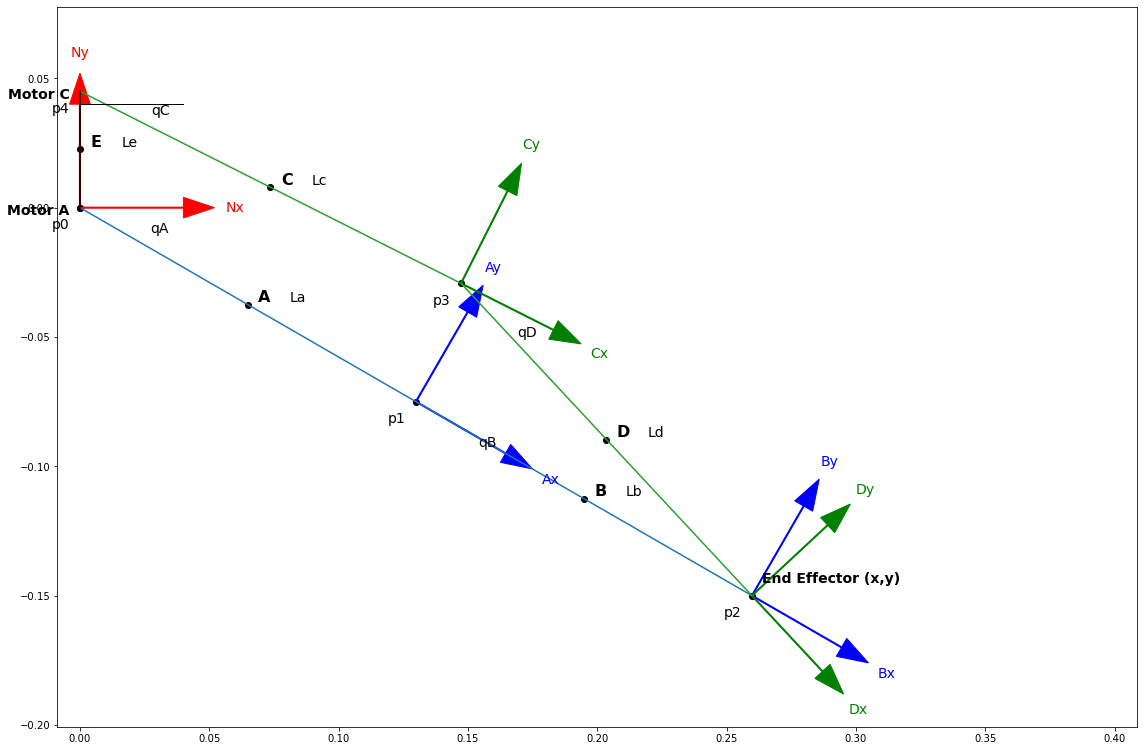

In [34]:
# Valid initial condition
x = numpy.array([points.y[1][0][0], points.y[1][1][0], points.y[1][2][0], points.y[1][3][0], points.y[1][4][0],0])
y = numpy.array([points.y[1][0][1], points.y[1][1][1], points.y[1][2][1], points.y[1][3][1], points.y[1][4][1],0])
prettyplot(x,y)

## Solution

In [35]:
# F=ma
f,ma = system.getdynamics()

2021-03-14 21:35:05,946 - pynamics.system - INFO - getting dynamic equations


In [36]:
# Acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,eq_dd,return_lambda = True)

2021-03-14 21:35:06,120 - pynamics.system - INFO - solving a = f/m and creating function
2021-03-14 21:35:06,123 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-03-14 21:35:06,272 - pynamics.system - INFO - done solving a = f/m and creating function
2021-03-14 21:35:06,273 - pynamics.system - INFO - calculating function for lambdas


In [37]:
# Integration Tolerance
tol = 1e-12

In [38]:
# Time
tinitial = 0
tfinal = 6
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [39]:
# Integrate
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-03-14 21:35:06,320 - pynamics.integration - INFO - beginning integration
2021-03-14 21:35:06,320 - pynamics.system - INFO - integration at time 0000.00
2021-03-14 21:35:06,640 - pynamics.system - INFO - integration at time 0000.21
2021-03-14 21:35:06,956 - pynamics.system - INFO - integration at time 0002.86
2021-03-14 21:35:07,155 - pynamics.integration - INFO - finished integration


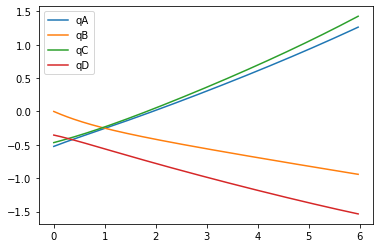

In [40]:
# Outputs
plt.figure()
artists = plt.plot(t,states[:,:4])
plt.legend(artists,['qA','qB','qC','qD'])

2021-03-14 21:35:07,318 - pynamics.output - INFO - calculating outputs
2021-03-14 21:35:07,324 - pynamics.output - INFO - done calculating outputs


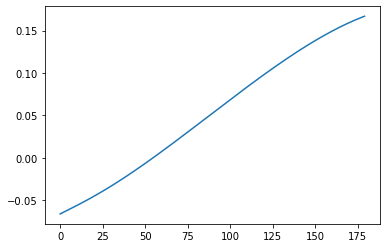

In [41]:
# Energy
KE = system.get_KE()
PE = system.getPEGravity(p0) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states)
energy_output.plot_time()

2021-03-14 21:35:07,424 - pynamics.output - INFO - calculating outputs
2021-03-14 21:35:07,430 - pynamics.output - INFO - done calculating outputs


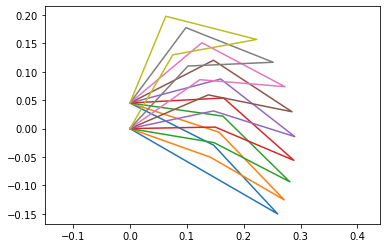

In [42]:
# Motion
points = [p0,p1,p2A,p3,p4]
points_output = PointsOutput(points,system)
y = points_output.calc(states)
points_output.plot_time(20)

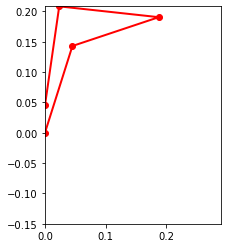

In [43]:
# Motion Animation
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [44]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())